[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds4v/absa-vlsp-2018/blob/main/experiments/Hotel-v1.ipynb)

In [1]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q datasets
!pip install -q accelerate
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 require

In [2]:
!git clone https://github.com/ds4v/absa-vlsp-2018.git
%cd ./absa-vlsp-2018/experiments
!mkdir predictions
!ls

Cloning into 'absa-vlsp-2018'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 225 (delta 61), reused 106 (delta 36), pack-reused 89
Receiving objects: 100% (225/225), 31.72 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/absa-vlsp-2018/experiments
Hotel-v1.ipynb	Hotel-v2.ipynb	predictions  Restaurant-v1.ipynb  Restaurant-v2.ipynb


In [3]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
sys.path.append('..')
tf.__version__

'2.15.0'

In [4]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Constants Setup and Load the Data

In [5]:
TRAIN_PATH = r'../datasets/vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv'
VAL_PATH = r'../datasets/vlsp2018_hotel/2-VLSP2018-SA-Hotel-dev.csv'
TEST_PATH = r'../datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.csv'
PRETRAINED_MODEL = 'vinai/phobert-base'
MODEL_NAME = 'Hotel-v2' # Multitask model on Hotel domain
MAX_LENGTH = 256
BATCH_SIZE = 25
EPOCHS = 20

In [6]:
from processors.vlsp2018_processor import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATUR

# Preprocess and Tokenize the Data

In [7]:
from processors.vietnamese_processor import VietnameseTextPreprocessor

# You should be carefull when using single word replacement for acronyms, because it can cause misinterpretation.
# For example, 'giá': ['price', 'gia'] can replace the word 'gia' in 'gia đình', making it become 'giá đình'.
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processors/VnCoreNLP', extra_teencodes={
    'khách sạn': ['ks'], 'nhà hàng': ['nhahang'], 'nhân viên': ['nv'],
    'cửa hàng': ['store', 'sop', 'shopE', 'shop'],
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'],
    'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],
    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'],
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'],
}, max_correction_length=MAX_LENGTH)

VnCoreNLP word segmenter is loaded successfully.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/360k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

bmd1905/vietnamese-correction-v2 is loaded successfully.


In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .')
print('Encode:', tokens, '\nDecode:', tokenizer.decode(tokens))
tokenizer.model_input_names

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2] 
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
# preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
# preprocessed_datasets.save_to_disk('../datasets/preprocessed_hotel')
# display(preprocessed_datasets)
# pd.DataFrame({
#     'raw_datasets': raw_datasets['train']['Review'][1480:1490],
#     'encoded_input_ids': preprocessed_datasets['train']['input_ids'][1480:1490],
#     'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(1480, 1490)]
# })

[INFO] Preprocessing and tokenizing text data...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFOR

,raw_datasets,encoded_input_ids,decoded_input_ids
0,Nhan viên phục vụ chu đáo Tuy chuyến du lịch c...,"[0, 650, 533, 5655, 2442, 550, 388, 7, 70, 66,...",<s> nhân_viên phục_vụ chu_đáo tuy chuyến du_lị...
1,"Bãi biển đẹp - Phục vụ tốt- Thức ăn ngon, giá ...","[0, 1162, 262, 258, 533, 167, 1849, 1325, 3401...",<s> bãi biển đẹp phục_vụ tốt thức_ăn ngon giá_...
2,Phòng nằm gần biển đẹp Phục vụ phòng t...,"[0, 292, 339, 124, 262, 258, 533, 292, 167, 58...",<s> phòng nằm gần biển đẹp phục_vụ phòng tốt d...
3,Nhân viên chuyên nghiệp tuyệt Khách sạn nằm ở ...,"[0, 650, 1564, 3518, 1299, 339, 25, 442, 9756,...",<s> nhân_viên chuyên_nghiệp tuyệt khách_sạn nằ...
4,Gia đình mình đã có 4 ngày 3 đêm lưu trú tại C...,"[0, 161, 68, 14, 10, 163, 43, 107, 396, 6567, ...",<s> gia_đình mình đã có 4 ngày 3 đêm lưu_trú t...
5,"Tôi ở đây 3 ngày 2 đêm, khách sạn không đúng v...","[0, 70, 25, 97, 107, 43, 76, 396, 1299, 17, 28...",<s> tôi ở đây 3 ngày 2 đêm khách_sạn không đún...
6,"Resort đẹp, Nhân viên phục vụ tận tình. Mình r...","[0, 9823, 258, 650, 533, 9787, 68, 59, 2273, 2...",<s> resort đẹp nhân_viên phục_vụ tận_tình mình...
7,Đây là lần đầu tiên chúng tôi đến Phú Quốc. Nh...,"[0, 97, 8, 101, 191, 283, 30, 56407, 3705, 595...",<s> đây là lần đầu_tiên chúng_tôi đến phú_quốc...
8,Tuy chuyến du lịch của tôi chỉ kéo dài có 3 ng...,"[0, 2442, 550, 388, 7, 70, 66, 832, 10, 107, 4...",<s> tuy chuyến du_lịch của tôi chỉ kéo_dài có ...
9,Bình Minh Resort Cable Car Vũng Tàu (KDL Cáp T...,"[0, 14872, 9823, 1395, 22820, 26283, 44439, 59...",<s> bình_minh resort cable car vũng_tàu khu cá...


In [44]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('../datasets/preprocessed_hotel')
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFOR

# Prepare for TensorFlow Training

In [45]:
# Tensorflow only accepts targeted column names prefixed with 'output_'
MULTI_BRANCH_NAMES = {old_name: f'output_{i + 1}' for i, old_name in enumerate(raw_datasets['train'].column_names[1:])}
preprocessed_datasets = preprocessed_datasets.rename_columns(MULTI_BRANCH_NAMES)
steps_per_epoch = len(preprocessed_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
print(MULTI_BRANCH_NAMES)

{'FACILITIES#CLEANLINESS': 'output_1', 'FACILITIES#COMFORT': 'output_2', 'FACILITIES#DESIGN&FEATURES': 'output_3', 'FACILITIES#GENERAL': 'output_4', 'FACILITIES#MISCELLANEOUS': 'output_5', 'FACILITIES#PRICES': 'output_6', 'FACILITIES#QUALITY': 'output_7', 'FOOD&DRINKS#MISCELLANEOUS': 'output_8', 'FOOD&DRINKS#PRICES': 'output_9', 'FOOD&DRINKS#QUALITY': 'output_10', 'FOOD&DRINKS#STYLE&OPTIONS': 'output_11', 'HOTEL#CLEANLINESS': 'output_12', 'HOTEL#COMFORT': 'output_13', 'HOTEL#DESIGN&FEATURES': 'output_14', 'HOTEL#GENERAL': 'output_15', 'HOTEL#MISCELLANEOUS': 'output_16', 'HOTEL#PRICES': 'output_17', 'HOTEL#QUALITY': 'output_18', 'LOCATION#GENERAL': 'output_19', 'ROOMS#CLEANLINESS': 'output_20', 'ROOMS#COMFORT': 'output_21', 'ROOMS#DESIGN&FEATURES': 'output_22', 'ROOMS#GENERAL': 'output_23', 'ROOMS#MISCELLANEOUS': 'output_24', 'ROOMS#PRICES': 'output_25', 'ROOMS#QUALITY': 'output_26', 'ROOM_AMENITIES#CLEANLINESS': 'output_27', 'ROOM_AMENITIES#COMFORT': 'output_28', 'ROOM_AMENITIES#DESIGN

In [65]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=list(MULTI_BRANCH_NAMES.values()),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=list(MULTI_BRANCH_NAMES.values()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=list(MULTI_BRANCH_NAMES.values()),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [66]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 1e-4,
    warmup_target = 2e-4,
    warmup_steps = int(total_steps * 0.15), # 15% of total_steps
    decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
    alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
))

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True, # You may obtain HIGHER metrics on the test set with longer training time if you set this to False
    # Because after some experiments, I found that even with higher val_loss, it still results in better metric reports on the test set.
    # This maybe because the training set and the test set have more similarities than the validation data.
    # But I think this is not fair, as we already have prior knowledge about the test set and we modified our training based on the performance on this set.
    # In real-world, we should only modify our training based on the performance on the validation data
    verbose = 1
)

# Fine-tuning with TensorFlow

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20


120/120 [==============================] - 133s 576ms/step - loss: 13.4663 - output_1_loss: 0.2622 - output_2_loss: 0.2421 - output_3_loss: 0.5772 - output_4_loss: 0.3292 - output_5_loss: 0.0964 - output_6_loss: 0.1431 - output_7_loss: 0.3277 - output_8_loss: 0.0637 - output_9_loss: 0.2149 - output_10_loss: 0.6547 - output_11_loss: 0.5773 - output_12_loss: 0.4296 - output_13_loss: 0.7129 - output_14_loss: 0.7562 - output_15_loss: 0.8814 - output_16_loss: 0.2070 - output_17_loss: 0.5635 - output_18_loss: 0.3564 - output_19_loss: 0.7928 - output_20_loss: 0.5936 - output_21_loss: 0.4946 - output_22_loss: 0.7854 - output_23_loss: 0.3722 - output_24_loss: 0.0459 - output_25_loss: 0.3210 - output_26_loss: 0.2932 - output_27_loss: 0.1824 - output_28_loss: 0.1995 - output_29_loss: 0.4302 - output_30_loss: 0.3110 - output_31_loss: 0.0521 - output_32_loss: 0.0353 - output_33_loss: 0.3243 - output_34_loss: 0.8372 - val_loss: 9.2001 - val_output_1_loss: 0.0830 - val_output_2_loss: 0.1629 - val_out

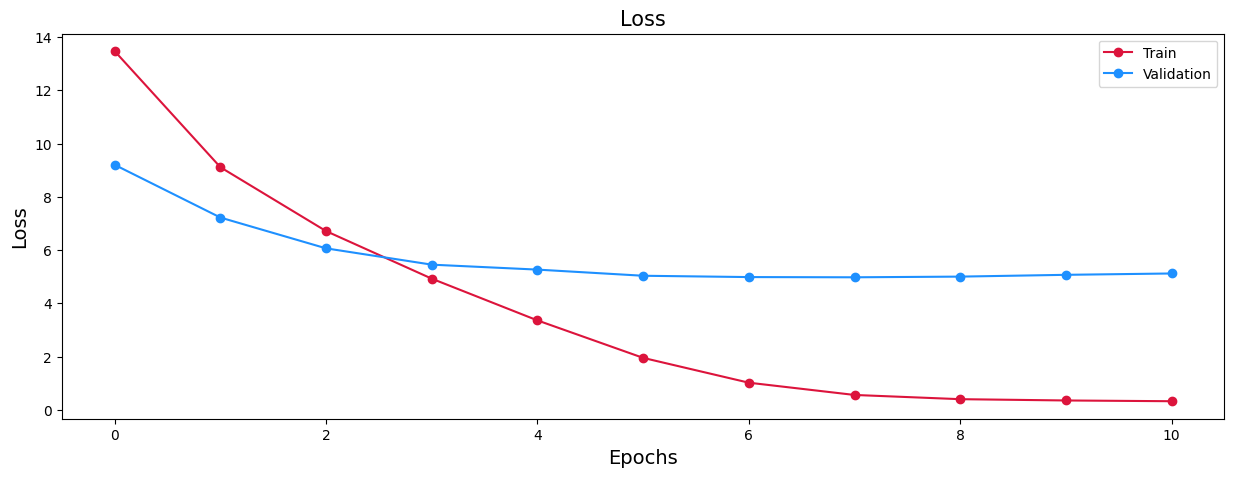

CPU times: user 7min 48s, sys: 1min 17s, total: 9min 5s
Wall time: 12min 4s


In [67]:
%%time
from acsa_model import VLSP2018MultiTask
from helper import plot_training_history
model = VLSP2018MultiTask(PRETRAINED_MODEL, MULTI_BRANCH_NAMES, optimizer, multi_branch=True, name=MODEL_NAME)

history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [early_stop_callback],
    epochs = EPOCHS,
    verbose = 1
).history

model.save_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}', save_format='tf')
plot_training_history(history)

In [72]:
from google.colab import drive # Move weights to Drive for faster downloading
drive.mount('/content/GoogleDrive', force_remount=True)
!zip -r ./weights/{MODEL_NAME}.zip ./weights/{MODEL_NAME}
!mv ./weights/{MODEL_NAME}.zip /content/GoogleDrive/My\ Drive

Mounted at /content/GoogleDrive
  adding: weights/Hotel-v2/ (stored 0%)
  adding: weights/Hotel-v2/Hotel-v2.index (deflated 80%)
  adding: weights/Hotel-v2/checkpoint (deflated 37%)
  adding: weights/Hotel-v2/Hotel-v2.data-00000-of-00001 (deflated 32%)


# Predict on the Test Data

In [73]:
from acsa_model import VLSP2018MultiTask
reloaded_model = VLSP2018MultiTask(PRETRAINED_MODEL, MULTI_BRANCH_NAMES, optimizer, multi_branch=True, name=MODEL_NAME)
reloaded_model.load_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}') # Reload the Model
reloaded_model.evaluate(val_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


80/80 [==============================] - 35s 120ms/step - loss: 4.9794 - output_1_loss: 0.0324 - output_2_loss: 0.1587 - output_3_loss: 0.3067 - output_4_loss: 0.0956 - output_5_loss: 0.0250 - output_6_loss: 0.0721 - output_7_loss: 0.1041 - output_8_loss: 0.0337 - output_9_loss: 0.0623 - output_10_loss: 0.1199 - output_11_loss: 0.1733 - output_12_loss: 0.0910 - output_13_loss: 0.4497 - output_14_loss: 0.2728 - output_15_loss: 0.2372 - output_16_loss: 0.3162 - output_17_loss: 0.1048 - output_18_loss: 0.0591 - output_19_loss: 0.1324 - output_20_loss: 0.1397 - output_21_loss: 0.2257 - output_22_loss: 0.2394 - output_23_loss: 0.1298 - output_24_loss: 0.0223 - output_25_loss: 0.0663 - output_26_loss: 0.0142 - output_27_loss: 0.1331 - output_28_loss: 0.2452 - output_29_loss: 0.3967 - output_30_loss: 0.0661 - output_31_loss: 0.0138 - output_32_loss: 0.0300 - output_33_loss: 0.1854 - output_34_loss: 0.2245


[4.979374885559082,
 0.03243863210082054,
 0.15866489708423615,
 0.3067288398742676,
 0.09564558416604996,
 0.025027627125382423,
 0.0721396654844284,
 0.10414005815982819,
 0.03374325856566429,
 0.06234736368060112,
 0.11988642066717148,
 0.1732860654592514,
 0.09102153033018112,
 0.44972583651542664,
 0.27279847860336304,
 0.23720715939998627,
 0.31621435284614563,
 0.1047910749912262,
 0.05914295092225075,
 0.13236814737319946,
 0.13967794179916382,
 0.2256615310907364,
 0.23936797678470612,
 0.12975770235061646,
 0.022257719188928604,
 0.06630702316761017,
 0.014179110527038574,
 0.13307131826877594,
 0.24521803855895996,
 0.396674245595932,
 0.06608866900205612,
 0.013829930685460567,
 0.02999497763812542,
 0.18542535603046417,
 0.22454629838466644]

In [74]:
y_pred = reloaded_model.acsa_predict(test_tf_dataset, BATCH_SIZE) # On test set
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
print('Example:', raw_datasets['test'][0]['Review'])
reloaded_model.print_acsa_pred(y_pred[0])

24/24 [==============================] - 8s 132ms/step - loss: 6.0214 - output_1_loss: 0.0405 - output_2_loss: 0.1821 - output_3_loss: 0.3147 - output_4_loss: 0.1277 - output_5_loss: 0.0990 - output_6_loss: 0.0789 - output_7_loss: 0.1962 - output_8_loss: 0.0372 - output_9_loss: 0.0592 - output_10_loss: 0.1478 - output_11_loss: 0.2015 - output_12_loss: 0.1090 - output_13_loss: 0.3056 - output_14_loss: 0.1576 - output_15_loss: 0.2441 - output_16_loss: 0.5600 - output_17_loss: 0.1500 - output_18_loss: 0.0727 - output_19_loss: 0.1651 - output_20_loss: 0.2198 - output_21_loss: 0.2491 - output_22_loss: 0.4156 - output_23_loss: 0.2582 - output_24_loss: 0.0567 - output_25_loss: 0.0974 - output_26_loss: 0.0435 - output_27_loss: 0.1479 - output_28_loss: 0.2254 - output_29_loss: 0.4184 - output_30_loss: 0.0940 - output_31_loss: 0.0403 - output_32_loss: 0.0165 - output_33_loss: 0.2696 - output_34_loss: 0.2202
Example: Ga giường không sạch, nhân viên quên dọn phòng một ngày.
=> ROOMS#CLEANLIN

In [75]:
from tensorflow.data import Dataset # On a random review by user
random_input = VLSP2018Loader.preprocess_and_tokenize(
    input('Enter your review: '), vn_preprocessor, tokenizer,
    batch_size=1, max_length=MAX_LENGTH
)
tf_inputs = Dataset.from_tensor_slices({x: [[random_input[x][0]]] for x in tokenizer.model_input_names})
random_pred = reloaded_model.acsa_predict(tf_inputs)
reloaded_model.print_acsa_pred(random_pred[0])

Enter your review: Lễ tân thân thiện, có thang máy, vị trí ks thuận tiện, view thành phố rất đẹp. Phòng sạch nhưng hơi nhỏ & thiếu bình đun siêu tốc. Sẽ quay lại & giới thiệu bạn bè
[INFO] Preprocessing and tokenizing text data...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/1 [==============================] - 7s 7s/step
=> HOTEL#GENERAL,positive
=> LOCATION#GENERAL,positive
=> ROOMS#CLEANLINESS,positive
=> ROOMS#DESIGN&FEATURES,negative
=> ROOM_AMENITIES#DESIGN&FEATURES,negative
=> SERVICE#GENERAL,positive


# Scikit-learn Evaluation

In [76]:
y_test = preprocessed_datasets['test'].remove_columns(tokenizer.model_input_names)
y_test = y_test.to_pandas().to_numpy()
y_test

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [77]:
from evaluators.sklearn_evaluator import VLSP2018SklearnEvaluator
sk_eval = VLSP2018SklearnEvaluator(y_test, y_pred, list(MULTI_BRANCH_NAMES))
# sk_eval.report(report_type='Aspect#Category,Polarity').round(3)
# sk_eval.report(report_type='Aspect#Category').round(3)
# sk_eval.report(report_type='Polarity').round(3)
# sk_eval.report(report_type='macro_avg').round(3)
sk_eval.report(report_type='all')

100%|██████████| 37/37 [00:00<00:00, 51421.22it/s]


ACSA Report (w/o "None" polarity) 
 Aspect#Category 
 Aspect#Category,Polarity 
 
 
 precision recall f1-score support precision recall f1-score support 
 
 
 
 FACILITIES#CLEANLINESS,negative 
 1.000 0.400 0.571 5 
 1.000 0.667 0.800 3 
 
 
 
 FACILITIES#CLEANLINESS,positive 
 
 1.000 0.000 0.000 2 
 
 
 
 FACILITIES#COMFORT,negative 
 0.000 0.000 0.000 26 
 1.000 0.000 0.000 6 
 
 
 
 FACILITIES#COMFORT,positive 
 
 0.000 0.000 0.000 20 
 
 
 
 FACILITIES#DESIGN&FEATURES,neutral 
 0.780 0.492 0.604 65 
 1.000 0.000 0.000 5 
 
 
 
 FACILITIES#DESIGN&FEATURES,negative 
 
 0.654 0.773 0.708 22 
 
 
 
 FACILITIES#DESIGN&FEATURES,positive 
 
 0.667 0.263 0.377 38 
 
 
 
 FACILITIES#GENERAL,neutral 
 0.440 0.524 0.478 21 
 1.000 0.000 0.000 1 
 
 
 
 FACILITIES#GENERAL,negative 
 
 0.000 0.000 0.000 1 
 
 
 
 FACILITIES#GENERAL,positive 
 
 0.435 0.526 0.476 19 
 
 
 
 FACILITIES#MISCELLANEOUS,negative 
 1.000 0.000 0.000 8 
 1.000 0.000 0.000 5 
 
 
 
 FACILITIES#MISCELLANEOUS,positive 
 
 1.000 0.000 0.000 3 
 
 
 
 FACILITIES#PRICES,neutral 
 0.667 0.154 0.250 13 
 1.000 0.000 0.000 2 
 
 
 
 FACILITIES#PRICES,negative 
 
 0.000 0.000 0.000 3 
 
 
 
 FACILITIES#PRICES,positive 
 
 1.000 0.250 0.400 8 
 
 
 
 FACILITIES#QUALITY,neutral 
 0.917 0.647 0.759 51 
 1.000 0.000 0.000 2 
 
 
 
 FACILITIES#QUALITY,negative 
 
 0.741 0.800 0.769 25 
 
 
 
 FACILITIES#QUALITY,positive 
 
 1.000 0.375 0.545 24 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,negative 
 1.000 0.000 0.000 3 
 1.000 0.000 0.000 2 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,positive 
 
 1.000 0.000 0.000 1 
 
 
 
 FOOD&DRINKS#PRICES,negative 
 0.000 0.000 0.000 9 
 0.000 0.000 0.000 3 
 
 
 
 FOOD&DRINKS#PRICES,positive 
 
 0.000 0.000 0.000 6 
 
 
 
 FOOD&DRINKS#QUALITY,neutral 
 0.945 0.938 0.942 129 
 1.000 0.429 0.600 14 
 
 
 
 FOOD&DRINKS#QUALITY,negative 
 
 0.850 0.895 0.872 19 
 
 
 
 FOOD&DRINKS#QUALITY,positive 
 
 0.912 0.969 0.939 96 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,neutral 
 0.920 0.831 0.873 124 
 1.000 0.167 0.286 6 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,negative 
 
 0.875 0.840 0.857 75 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,positive 
 
 0.846 0.767 0.805 43 
 
 
 
 HOTEL#CLEANLINESS,negative 
 0.873 0.821 0.846 67 
 0.500 0.250 0.333 8 
 
 
 
 HOTEL#CLEANLINESS,positive 
 
 0.898 0.898 0.898 59 
 
 
 
 HOTEL#COMFORT,neutral 
 0.768 0.670 0.716 94 
 1.000 0.000 0.000 1 
 
 
 
 HOTEL#COMFORT,negative 
 
 0.125 0.077 0.095 13 
 
 
 
 HOTEL#COMFORT,positive 
 
 0.797 0.738 0.766 80 
 
 
 
 HOTEL#DESIGN&FEATURES,neutral 
 0.831 0.812 0.821 85 
 1.000 0.000 0.000 3 
 
 
 
 HOTEL#DESIGN&FEATURES,negative 
 
 0.375 0.375 0.375 8 
 
 
 
 HOTEL#DESIGN&FEATURES,positive 
 
 0.853 0.865 0.859 74 
 
 
 
 HOTEL#GENERAL,neutral 
 0.887 0.834 0.860 151 
 0.500 0.250 0.333 4 
 
 
 
 HOTEL#GENERAL,negative 
 
 0.750 0.500 0.600 12 
 
 
 
 HOTEL#GENERAL,positive 
 
 0.879 0.859 0.869 135 
 
 
 
 HOTEL#MISCELLANEOUS,neutral 
 0.562 0.132 0.214 68 
 1.000 0.000 0.000 5 
 
 
 
 HOTEL#MISCELLANEOUS,negative 
 
 0.438 0.206 0.280 34 
 
 
 
 HOTEL#MISCELLANEOUS,positive 
 
 1.000 0.000 0.000 29 
 
 
 
 HOTEL#PRICES,neutral 
 0.808 0.831 0.819 71 
 1.000 0.000 0.000 2 
 
 
 
 HOTEL#PRICES,negative 
 
 0.300 0.500 0.375 6 
 
 
 
 HOTEL#PRICES,positive 
 
 0.841 0.841 0.841 63 
 
 
 
 HOTEL#QUALITY,neutral 
 0.667 0.462 0.545 13 
 1.000 0.000 0.000 1 
 
 
 
 HOTEL#QUALITY,negative 
 
 0.400 0.400 0.400 5 
 
 
 
 HOTEL#QUALITY,positive 
 
 0.750 0.429 0.545 7 
 
 
 
 LOCATION#GENERAL,neutral 
 0.968 0.964 0.966 221 
 0.667 0.133 0.222 15 
 
 
 
 LOCATION#GENERAL,negative 
 
 0.545 0.750 0.632 16 
 
 
 
 LOCATION#GENERAL,positive 
 
 0.949 0.974 0.961 190 
 
 
 
 ROOMS#CLEANLINESS,neutral 
 0.922 0.940 0.931 200 
 1.000 0.000 0.000 7 
 
 
 
 ROOMS#CLEANLINESS,negative 
 
 0.840 0.778 0.808 27 
 
 
 
 ROOMS#CLEANLINESS,positive 
 
 0.899 0.970 0.933 166 
 
 
 
 ROOMS#COMFORT,neutral 
 0.737 0.785 0.760 93 
 1.000 0.000 0.000 2 
 
 
 
 ROOMS#COMFORT,negative 
 
 0.630 0.548 0.586 31 
 
 
 
 ROOMS#COMFORT,po

# VLSP Evaluation

In [78]:
from processors.vlsp2018_processor import VLSP2018Parser
VLSP2018Parser.vlsp_save_as(f'./predictions/{MODEL_NAME}.txt', raw_datasets['test']['Review'], y_pred, MULTI_BRANCH_NAMES)
!java ../evaluators/SAEvaluate.java {TEST_PATH.replace('.csv', '.txt')} ./predictions/{MODEL_NAME}.txt

600it [00:00, 64847.00it/s]


Row mismatch:﻿#1 <-> #1
Evaluation Result >> File:./predictions/Hotel-v2.txt<> [../datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.txt]
                    Gold count	46	416	200	93	221	57	198	67	68	144	32	124	10	65	85	51	13	71	151	29	94	21	68	59	8	26	129	3	13	9	5	4	3	1
                  ANSWER count	28	419	204	99	220	36	186	63	34	109	32	112	4	41	83	36	9	73	142	27	82	25	16	46	0	1	128	0	3	3	2	0	0	0

        Correct ANSWER: aspect	20	408	188	73	213	26	169	55	29	89	23	103	4	32	69	33	6	59	126	21	63	11	9	29	0	0	121	0	2	0	2	0	0	0
             Precision: aspect	0.7143	0.9737	0.9216	0.7374	0.9682	0.7222	0.9086	0.8730	0.8529	0.8165	0.7188	0.9196	1.0000	0.7805	0.8313	0.9167	0.6667	0.8082	0.8873	0.7778	0.7683	0.4400	0.5625	0.6304	0.0000	0.0000	0.9453	0.0000	0.6667	0.0000	1.0000	0.0000	0.0000	0.0000
                Recall: aspect	0.4348	0.9808	0.9400	0.7849	0.9638	0.4561	0.8535	0.8209	0.4265	0.6181	0.7188	0.8306	0.4000	0.4923	0.8118	0.6471	0.4615	0.8310	0.8344	0.7241	0.6702	0.5238	0.1324	0.4915	0.